# EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.vectorized
import shapely.ops as shapely_ops

from glob import glob
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

In [2]:
import os
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print("The code directory is located at", CODE_DIR)
sys.path.append(CODE_DIR)

The code directory is located at ./../../code


In [3]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries

In [4]:
%matplotlib inline

## Fingerprint Extraction

In [5]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "B1"

fingerprint_files = list(glob(f"../../data/wifi_fingerprint_manual/train/{site_id}/{floor_id}/*_wifi_fingerprint.csv"))

In [6]:
def get_band(freq):
  d2400 = np.abs(freq - 2400)
  d5000 = np.abs(freq - 5000)
  band = np.zeros_like(freq)
  band[d2400 < d5000] = 2400
  band[d2400 >= d5000] = 5000
  return band


def extract_bssid_set(wifi_fingerprint_df_list):
  bssid_set = set()

  for df in wifi_fingerprint_df_list:
    unique_bssid_list = df["bssid"].unique().tolist()
    bssid_set.update(unique_bssid_list)

  return bssid_set


def extract_ssid_set(wifi_fingerprint_df_list):
  ssid_set = set()

  for df in wifi_fingerprint_df_list:
    unique_ssid_list = df["ssid"].unique().tolist()
    ssid_set.update(unique_ssid_list)

  return ssid_set


def create_fingerprint_vector(group_data: pd.DataFrame,
                              bssid_vector: np.ndarray,
                              not_seen_rssi: float = -1000) -> np.ndarray:
  v = np.zeros_like(bssid_vector, dtype=np.float32) + not_seen_rssi

  for bssid, rssi in group_data[["bssid", "rssi"]].values:
    v[bssid_vector == bssid] = rssi

  return v


def extract_fingerprint_df(fingerprint_files, wifi_band=(2400, 5000)):
  if isinstance(wifi_band, int):
    wifi_band = {wifi_band}

  wifi_fingerprint_df_list = [pd.read_csv(file) for file in fingerprint_files]

  # Adding frequency band
  for df in wifi_fingerprint_df_list:
    df["freq_band"] = get_band(df["freq"].values)

  wifi_fingerprint_fb_df_list = [
      df[df["freq_band"].isin(wifi_band)] for df in wifi_fingerprint_df_list
  ]

  bssid_set = extract_bssid_set(wifi_fingerprint_fb_df_list)
  ssid_set = extract_ssid_set(wifi_fingerprint_fb_df_list)
  print(f"The number of unique BSSIDs: {len(bssid_set)}")
  print(f"The number of unique SSIDs: {len(ssid_set)}")
  bssid_vector = np.array(list(bssid_set))

  fingerprint_tuples = []
  for df in tqdm(wifi_fingerprint_fb_df_list):
    for (sys_ts, x, y), group_data in df.groupby(["sys_ts", "x", "y"]):
      fingerprint_vector = create_fingerprint_vector(group_data,
                                                     bssid_vector,
                                                     not_seen_rssi=-1000)
      fingerprint_tuples.append((x, y, fingerprint_vector))

  print(f"The number of fingerprints: {len(fingerprint_tuples)}")

  return pd.DataFrame(fingerprint_tuples, columns=["x", "y", "v"]), bssid_vector

In [7]:
wifi_fingerprint_df_list = [pd.read_csv(file) for file in fingerprint_files]

In [8]:
fingerprint_df, bssid_vector = extract_fingerprint_df(fingerprint_files, wifi_band=2400)

The number of unique BSSIDs: 1008
The number of unique SSIDs: 457


100%|██████████| 219/219 [00:04<00:00, 43.95it/s]

The number of fingerprints: 4787


## Floormap Extraction

In [9]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

In [10]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


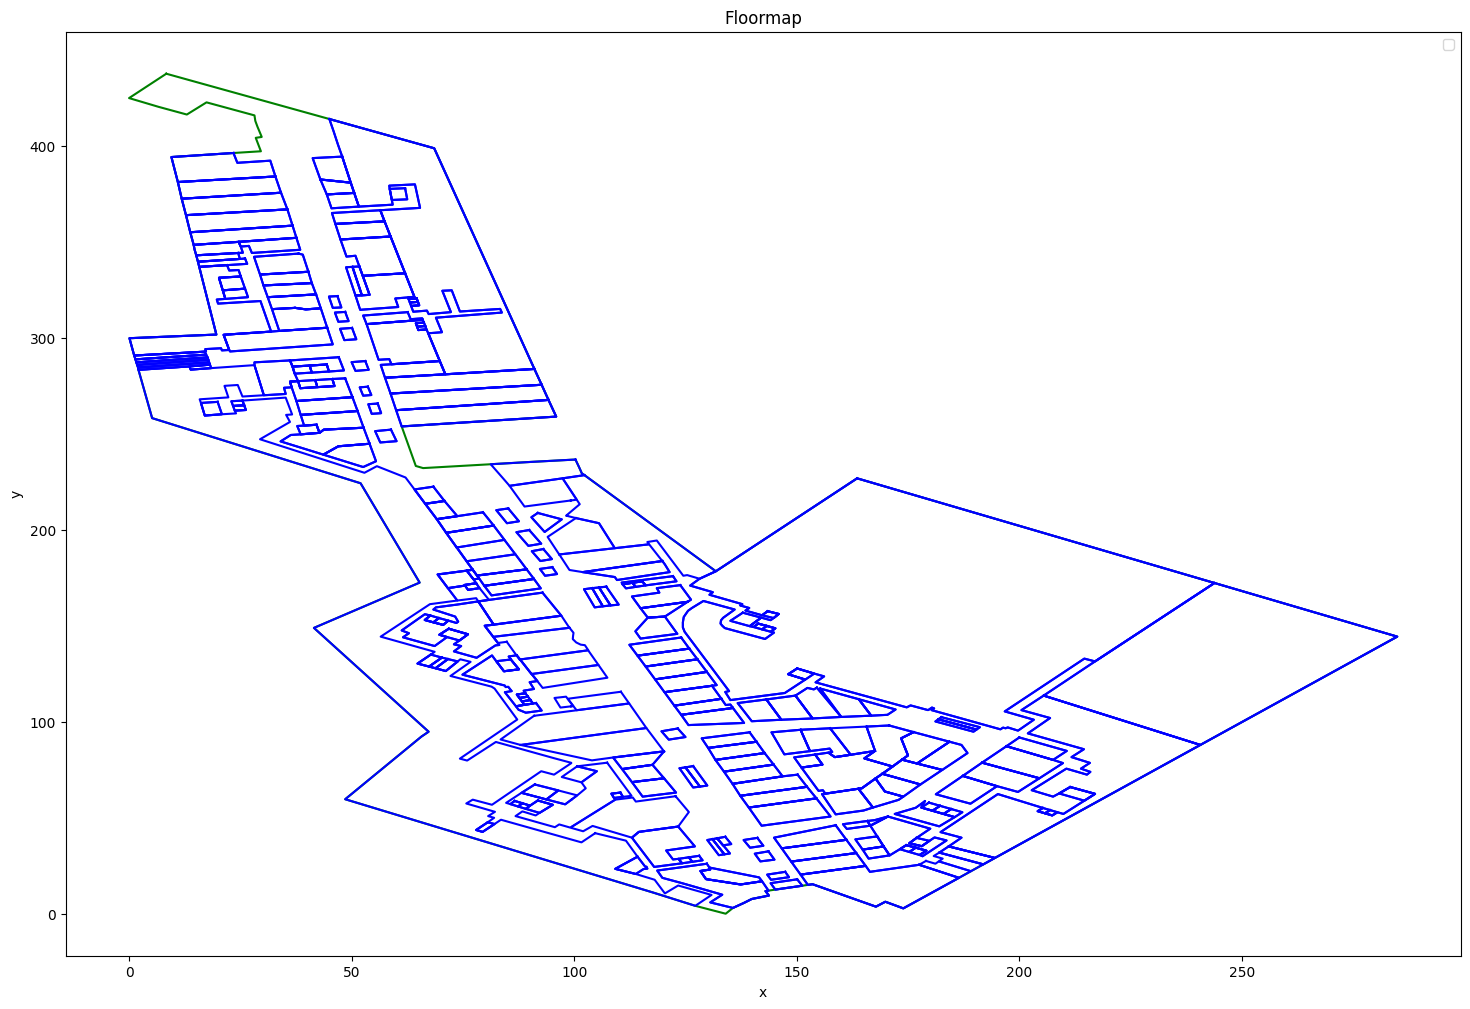

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## Coverage of Fingerprint's Locations

In [12]:
union_floor_polygon = shapely_ops.unary_union(floor_polygons)
union_store_polygon = shapely_ops.unary_union(store_polygons)
floor_hallway = union_floor_polygon.difference(union_store_polygon)

In [13]:
# Generate search grid

grid_resolution = 2  # 5 meters
grid_xs = np.arange(0, width_meter, grid_resolution) + grid_resolution / 2
grid_ys = np.arange(0, height_meter, grid_resolution) + grid_resolution / 2

grid_x, grid_y = np.meshgrid(grid_xs, grid_ys)
search_space_mask = shapely.vectorized.contains(floor_hallway, grid_x, grid_y)
bin_x, bin_y = grid_x[search_space_mask], grid_y[search_space_mask]

In [14]:
fingerprint_x, fingerprint_y = fingerprint_df["x"].values, fingerprint_df["y"].values

In [15]:
bin_points = np.vstack((bin_x, bin_y)).T
fingerprint_points = np.vstack((fingerprint_x, fingerprint_y)).T

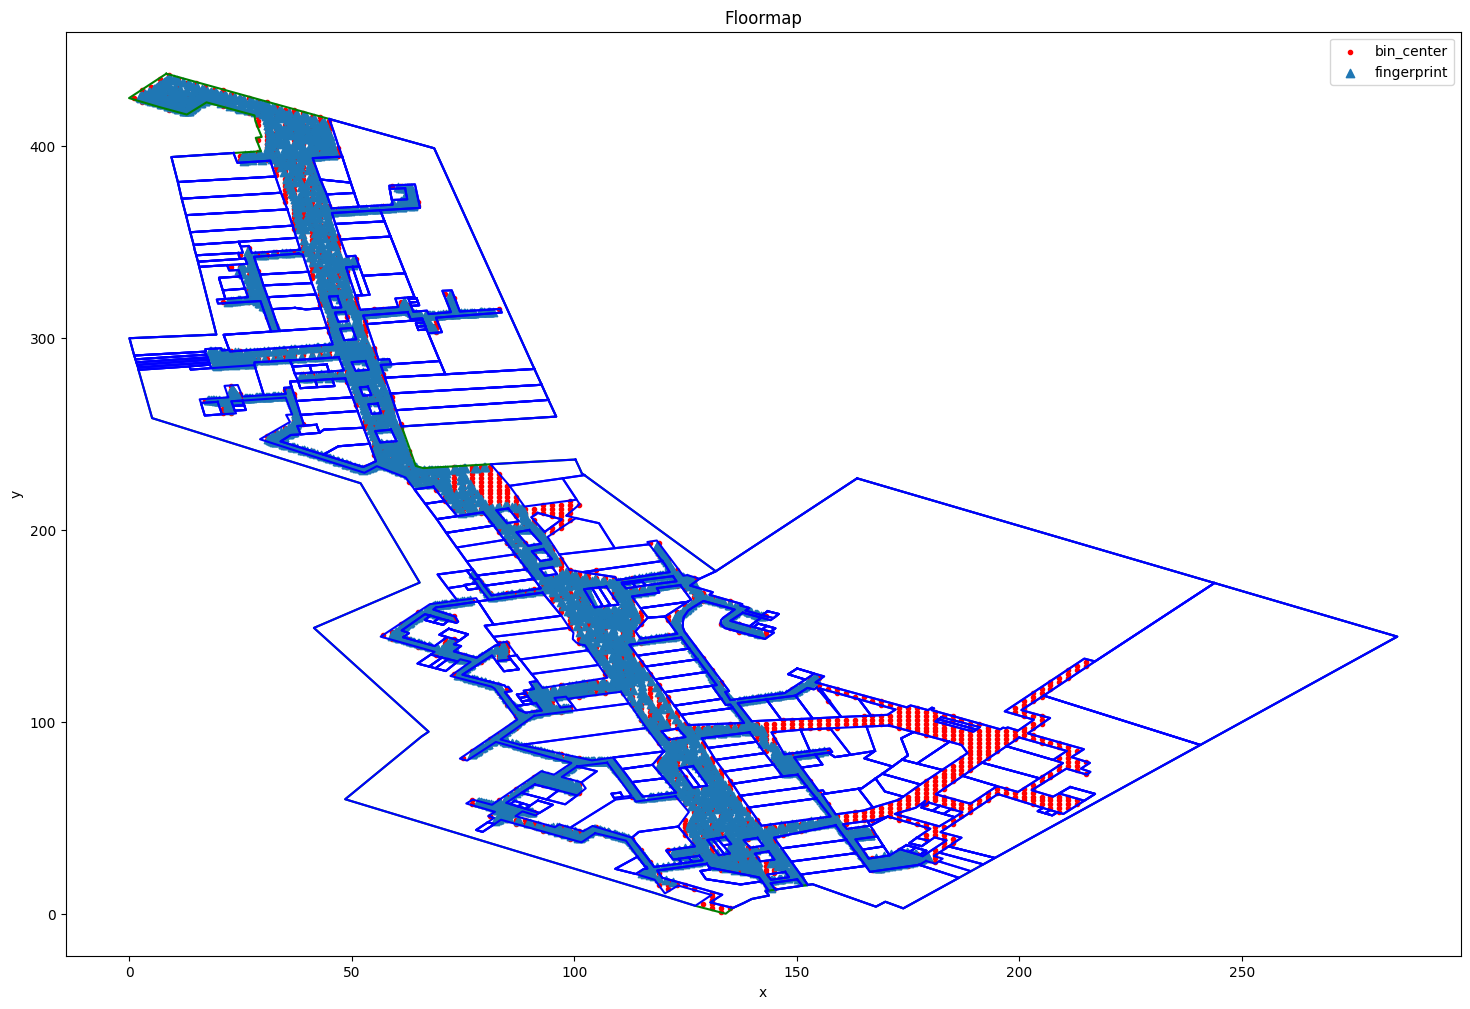

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.scatter(bin_points[:, 0], bin_points[:, 1], marker=".", color="red", label="bin_center")
ax.scatter(fingerprint_points[:, 0], fingerprint_points[:, 1], marker="^", label="fingerprint")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [17]:
nn = NearestNeighbors(n_neighbors=2, algorithm="ball_tree", n_jobs=-1).fit(fingerprint_points)

In [18]:
distance, indices = nn.kneighbors(bin_points, n_neighbors=1)

In [19]:
coverage_pct = 1.0 - np.count_nonzero(distance >= grid_resolution) / distance.shape[0]

In [21]:
print(f"Coverage percentage: {coverage_pct * 100:.2f}%")

Coverage percentage: 81.75%


## Track's Summary Statistics

In [23]:
def get_track_duration(waypoint_df: pd.DataFrame) -> float:
  """
  Compute the duration of track, in seconds.
  Args:
    waypoint_df: a pd.DataFrame of waypoints
  Returns:
    a float represents the duration of track, in seconds
  """
  sys_ts = waypoint_df["sys_ts"].values
  return (sys_ts[-1] - sys_ts[0]) / 1000

In [24]:
def get_track_length(waypoint_df: pd.DataFrame) -> float:
  """
  Compute the length of track, in meters.
  Args:
    waypoint_df: a pd.DataFrame of waypoints
  Returns:
    a float represents the length of track, in meters
  """
  xy = waypoint_df[["x", "y"]].values
  return np.linalg.norm(xy[1:] - xy[:-1], axis=1).sum()

In [25]:
waypoint_files = list(glob(f"../../data/wifi_fingerprint_manual/train/{site_id}/{floor_id}/*_waypoint.csv"))

In [26]:
def get_track_stats(waypoint_files: list[str]) -> pd.DataFrame:
  track_stats = []

  for waypoint_file_path in waypoint_files:
    track_name = os.path.basename(waypoint_file_path)[:-len("_waypoint.csv")]
    waypoint_df = pd.read_csv(waypoint_file_path)
    track_duration = get_track_duration(waypoint_df)
    track_length = get_track_length(waypoint_df)
    track_stats.append({
        "track_id": track_name,
        "duration": track_duration,
        "length": track_length,
    })

  return pd.DataFrame(track_stats)

In [27]:
track_stats_df_list = []

site_file_path_list = glob(f"../../data/wifi_fingerprint_manual/train/*")

for site_file_path in site_file_path_list:
  site_id = os.path.basename(site_file_path)

  track_file_path_list = list(glob(site_file_path + "/*"))
  for track_file_path in track_file_path_list:
    floor_id = os.path.basename(track_file_path)
    
    waypoint_files = list(glob(track_file_path + "/*_waypoint.csv"))
    track_stats_df = get_track_stats(waypoint_files)
    track_stats_df["site_id"] = site_id
    track_stats_df["floor_id"] = floor_id

    track_stats_df_list.append(track_stats_df)

In [28]:
track_stats_df_all = pd.concat(track_stats_df_list)

In [29]:
!mkdir -p ../../data/output

In [30]:
track_stats_df_all.to_csv("../../data/output/track_stats_all.csv", index=False)

## Train/Test Split

* We perform a train/test split procedure based on the amount of time spent on collecting tracks.

In [31]:
track_stats_df_all["site_id"] = track_stats_df_all["site_id"].astype("category")
track_stats_df_all["floor_id"] = track_stats_df_all["floor_id"].astype("category")

In [33]:
def train_test_split_track(group_data: pd.DataFrame, test_size: float=0.2) -> pd.DataFrame:
  group_data = group_data[group_data["duration"] > 0].copy()
  
  group_data.sort_values("duration", ascending=False, inplace=True)
  duration_pct = group_data["duration"].values / group_data["duration"].values.sum()
  duration_csum = np.cumsum(duration_pct)
  group_data["dataset"] = "train"
  group_data.loc[duration_csum > 1.0 - test_size, "dataset"] = "test"

  return group_data

In [36]:
group_data = track_stats_df_all[
    (track_stats_df_all["site_id"] == "5da138b74db8ce0c98bd4774") &
    (track_stats_df_all["floor_id"] == "F5")]

train_test_split_track(group_data)

,track_id,duration,length,site_id,floor_id,dataset
15,5db1630ae62491000652bd8d,180.496,148.860615,5da138b74db8ce0c98bd4774,F5,train
25,5db1691aec4254000601bf11,178.132,174.018906,5da138b74db8ce0c98bd4774,F5,train
129,5db15a482aaa8f0006512921,155.001,122.393025,5da138b74db8ce0c98bd4774,F5,train
69,5db15a532aaa8f000651292d,150.978,175.028999,5da138b74db8ce0c98bd4774,F5,train
11,5db163142aaa8f00065129b2,131.351,123.454412,5da138b74db8ce0c98bd4774,F5,train
...,...,...,...,...,...,...
93,5db15a4ee62491000652bd3c,5.088,6.443730,5da138b74db8ce0c98bd4774,F5,test
45,5db1692cec4254000601bf21,4.112,6.289794,5da138b74db8ce0c98bd4774,F5,test
9,5db1691cec4254000601bf13,3.521,4.603981,5da138b74db8ce0c98bd4774,F5,test
126,5db2ad17ec4254000601c135,3.476,3.633096,5da138b74db8ce0c98bd4774,F5,test


In [37]:
test_size = 0.2
train_test_splited = []

for (site_id, floor_id), group_data in track_stats_df_all.groupby(["site_id", "floor_id"]):
  print(f"site_id={site_id}, floor_id={floor_id}")
  train_test_splited.append(train_test_split_track(group_data, test_size=test_size))

site_id=5a0546857ecc773753327266, floor_id=B1
site_id=5a0546857ecc773753327266, floor_id=F1
site_id=5a0546857ecc773753327266, floor_id=F2
site_id=5a0546857ecc773753327266, floor_id=F3
site_id=5a0546857ecc773753327266, floor_id=F4
site_id=5c3c44b80379370013e0fd2b, floor_id=B1
site_id=5c3c44b80379370013e0fd2b, floor_id=F1
site_id=5c3c44b80379370013e0fd2b, floor_id=F2
site_id=5c3c44b80379370013e0fd2b, floor_id=F3
site_id=5c3c44b80379370013e0fd2b, floor_id=F4
site_id=5c3c44b80379370013e0fd2b, floor_id=F5
site_id=5cd56865eb294480de7167b6, floor_id=F1
site_id=5cd56865eb294480de7167b6, floor_id=F2
site_id=5cd56865eb294480de7167b6, floor_id=F3
site_id=5cd56865eb294480de7167b6, floor_id=F4
site_id=5cd56865eb294480de7167b6, floor_id=F5
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F1
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F2
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F3
site_id=5cd56b5ae2acfd2d33b58544, floor_id=F4
site_id=5cd56b5ae2acfd2d33b58546, floor_id=B1
site_id=5cd56b5ae2acfd2d33b58546, 

In [38]:
train_test_assignment = pd.concat(train_test_splited)

In [39]:
train_test_assignment.head()

,track_id,duration,length,site_id,floor_id,dataset
78,5e1580ccf4c3420006d520e0,107.339,90.026316,5a0546857ecc773753327266,B1,train
22,5e1580c51506f2000638fc6a,89.977,66.943107,5a0546857ecc773753327266,B1,train
73,5e15731ca280850006f3d011,88.834,55.475635,5a0546857ecc773753327266,B1,train
46,5e15731fa280850006f3d013,79.605,48.154400,5a0546857ecc773753327266,B1,train
62,5e157321a280850006f3d015,78.439,54.540528,5a0546857ecc773753327266,B1,train


In [40]:
train_test_assignment.to_csv("../../data/output/train_test_assignment.csv", index=False, header=True)